In [2]:
import numpy as np
from matplotlib import pyplot as plt
import sys
sys.path.append('../src')
from geometry import *
from tubes import closed_geometry
from solver import stokes2d
from joblib import Parallel, delayed

/home/haiy/pkg/miniconda3/envs/bim/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [32]:
p1 = np.array([-5,-1])
curve1 = line

p2 = np.array([-1,-1])
curve2 = line

p3 = np.array([-1,-5])
curve3 = cap

p4 = np.array([1,-5])
curve4 = line

p5 = np.array([1,1])
curve5 = line

p6 = np.array([-5,1])
curve6 = cap

In [33]:
pts = [p1, p2, p3, p4, p5, p6]
curves = [curve1, curve2, curve3, curve4, curve5, curve6]

In [48]:
band = closed_geometry(pts,curves,corner_size=1)
band.build_geometry(max_distance=0.01)

In [49]:
pts

[array([-5, -1]),
 array([-1, -1]),
 array([-1, -5]),
 array([ 1, -5]),
 array([1, 1]),
 array([-5,  1])]

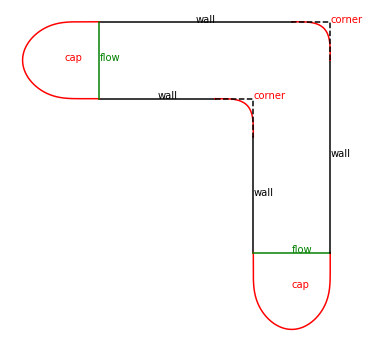

In [53]:
fig, ax = plt.subplots(figsize=(5,5))
ax.set_aspect(1)
ax.axis('off')
fig.tight_layout()

for i in band.curves:
    if isinstance(i,line):
        __ = np.array([i.p1,i.p2])
        ax.plot(__[:,0],__[:,1],c='black')
        ax.text(*(__.mean(axis=0)),'wall',c='black')
        
    if isinstance(i,cap):
        ax.plot(i.x,i.y,c='red')
        __ = np.array([i.p1,i.p2])
        ax.plot(__[:,0],__[:,1],c='green')
        ax.text(*(__.mean(axis=0)),'flow',c='green')
        ax.text(i.x.mean(), i.y.mean(), 'cap', c='red')

    if isinstance(i,corner):
        ax.plot(i.x,i.y,c='red')
        __ = np.array((i.p1,i.p_,i.p2)).T
        ax.plot(__[0],__[1],c='black',linestyle='dashed')
        ax.text(*i.p_,s='corner',c='red')
